In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

import os
cwd=os.getcwd()
os.chdir(cwd[:len('StableRemaster')+cwd.find('StableRemaster')])

from tqdm import tqdm

from diffusers import StableDiffusionInpaintPipeline
from PIL import Image

In [2]:
from src import *

In [3]:
DATA_PATH = './data/02_scenes/'

In [4]:
torch.cuda.is_available()

True

In [5]:
cap_path = f'{DATA_PATH}atla_s1e1-Scene-151.mp4'
frames = split_video(cap_path)

In [6]:
segmenter = background_segmentation_loader()

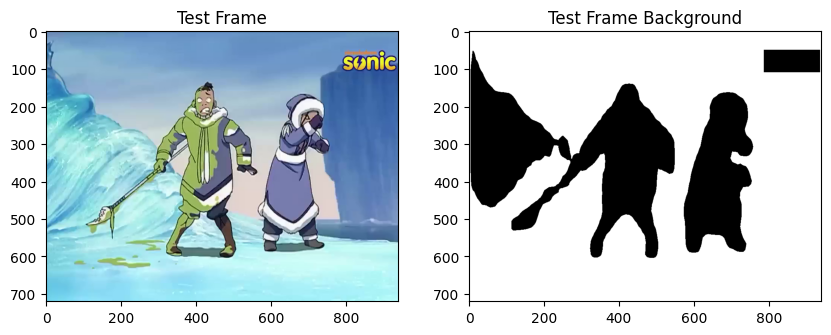

In [7]:
test_frame1 = frames[0]

bg1,bg_mask1 = segmenter(test_frame1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame1, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask1, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

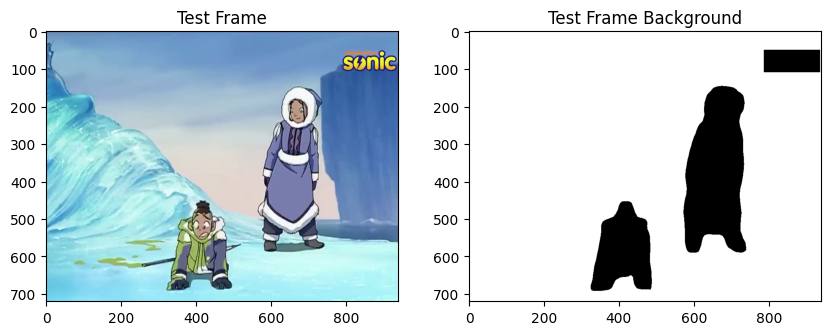

In [8]:
test_frame2 = frames[70]

bg2, bg_mask2 = segmenter(test_frame2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame2, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask2, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

In [9]:
stitched_im, stitched_mask, M = stitch_images(test_frame1, test_frame2, bg_mask1, bg_mask2)

In [10]:
masks = []
bgs = []
for frame in tqdm(frames):
    bg, bg_mask = segmenter(frame,mask_conf=0.2,cat_conf=0.4)
    masks.append(bg_mask)
    bgs.append(bg)

100%|██████████| 132/132 [00:15<00:00,  8.37it/s]


In [11]:
total_bg, total_mask, Ms = stitch_multiple(frames, masks)

100%|██████████| 131/131 [00:32<00:00,  4.06it/s]


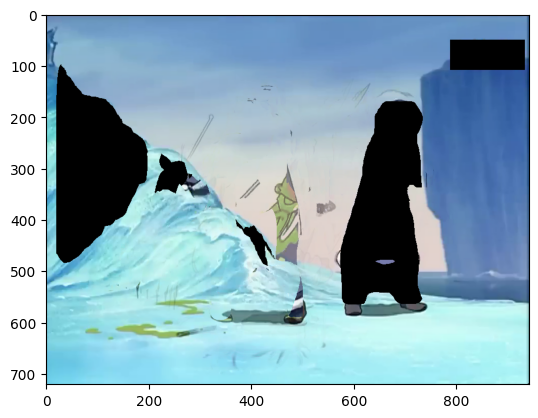

In [12]:
plt.imshow(total_bg,'gray')

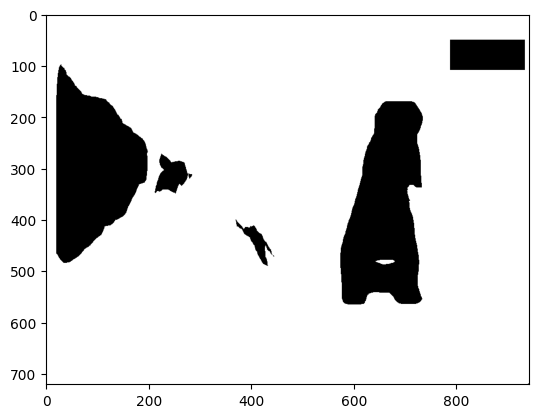

In [13]:
plt.imshow(total_mask,'gray')

In [14]:
def get_new_window_padding(frame_shape):
    new_width = frame_shape[0]*16//9
    padding = (new_width-frame_shape[1])//2
    return padding

def get_new_window_mask(frame_shape):
    new_width = frame_shape[0]*16//9
    new_window_mask = np.ones((frame_shape[0],new_width))
    left_bar = (new_width-frame_shape[1])//2
    right_bar = new_width-left_bar
    new_window_mask[:,left_bar:right_bar]=0
    return new_window_mask

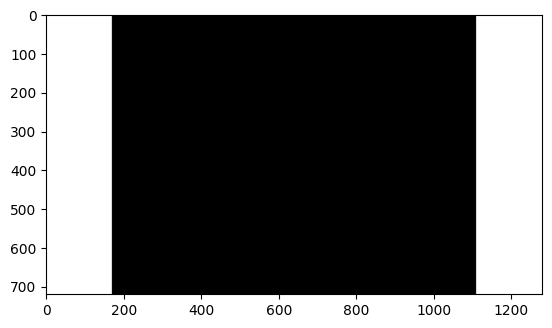

In [15]:
new_window_mask=get_new_window_mask(test_frame1.shape)
plt.imshow(new_window_mask,'gray')

In [16]:
pipe = get_sd_pipe()

Device: CUDA
------------------------------


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
D:\anaconda\envs\stare\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [40]:
def get_sample_boxes(frame_shape, sample_shape):
    assert(sample_shape[1]<frame_shape[1])
    assert(sample_shape[0]<frame_shape[0])
    x_samples = np.ceil(frame_shape[1]/sample_shape[1]).astype(int)
    y_samples = np.ceil(frame_shape[0]/sample_shape[0]).astype(int)
    
    x_pix_overlap = x_samples*sample_shape[1]-frame_shape[1]
    y_pix_overlap = y_samples*sample_shape[0]-frame_shape[0]
    
    x_pix_offset = x_pix_overlap//(x_samples-1)
    y_pix_offset = y_pix_overlap//(y_samples-1)
    
    x_starts = np.zeros(x_samples)
    y_starts = np.zeros(y_samples)
    
    for i in range(1,len(x_starts)):
        x_starts[i]=i*sample_shape[1]-x_pix_offset*i
        if x_pix_offset!=x_pix_overlap:
            x_starts[i]-=1
            x_pix_overlap-=1
            
    for i in range(1,len(y_starts)):
        y_starts[i]=i*sample_shape[0]-y_pix_offset*i
        if y_pix_offset!=y_pix_overlap:
            y_starts[i]-=1
            y_pix_overlap-=1
    
    box_starts = np.array(np.meshgrid(y_starts, x_starts)).T.reshape(-1, 2).astype(int)
    
    return box_starts

def outpaint_frame(frame, mask, sample_width=768, sample_height=512, pipe=None):
    frame=frame.copy()
    mask=mask.copy()
    sample_starts = get_sample_boxes(frame.shape[0:2],[sample_height,sample_width])
    for (y,x) in sample_starts:
        sub_frame = frame[y:(y+sample_height),x:(x+sample_width),:]
        sub_mask = mask[y:(y+sample_height),x:(x+sample_width)]
        if np.any(sub_mask):
            sub_frame = Image.fromarray(sub_frame).convert("RGB")
            sub_mask = Image.fromarray(sub_mask).convert("RGB")

            new_sub_frame = pipe(prompt='animated arctic iceberg background',image=sub_frame, 
                                 mask_image=sub_mask,height=sample_height,width=sample_width).images[0]
            frame[y:(y+sample_height),x:(x+sample_width),:] = np.array(new_sub_frame)
            mask[y:(y+sample_height),x:(x+sample_width)]=0
    return frame

In [86]:
def resample_frame(frame,mask,M, total_bg, total_mask, pipe):
    total_bg = total_bg.copy()
    total_mask = total_mask.copy()
    shape = frame.shape
    #need to pad total_bg and total_mask as well
    mask = (mask*-1+1).astype('uint8')
    p_frame, p_mask = get_pad_frame(frame,mask)
    # transform frame and mask?
    h, w = total_bg.shape[:2]
    h0,w0 = p_frame.shape[:2]
    t_frame = cv2.warpAffine(p_frame, M, (w,h))
    t_mask = cv2.warpAffine(p_mask, M, (w,h))
    # and mask w/ total_mask, then send to stable diffusion
    sd_mask = cv2.bitwise_and(t_mask , t_mask , mask = total_mask).astype('uint8')
    #send to stable diffusion w/ total_bg (only if the mask isn't all 0s?)
    
    #return t_frame,t_mask,sd_mask
    if np.any(sd_mask):
        print(total_bg.shape,sd_mask.shape)
        sd_mask=sd_mask*255
        total_bg2 = outpaint_frame(total_bg, sd_mask, pipe=pipe)
        #total_bg2 = pipe(prompt='',image=total_bg, mask_image=sd_mask).images[0]
    #total_mask = cv2.bitwise_xor(total_mask, sd_mask)
    sd_mask=sd_mask//255
    sd_mask = (-1*sd_mask+1).astype('uint8')
    total_mask2 = cv2.bitwise_and(total_mask,sd_mask)
    # sample new total_bg using mask
    sampled_pixels = cv2.bitwise_and(total_bg2 , total_bg2 , mask = t_mask).astype('uint8')
    
    #return total_bg2, sampled_pixels, total_mask2
    # add this sample to frame
    new_frame = np.sum([sampled_pixels, t_frame],axis=0)
    print(shape)
    frame_start = [((new_frame.shape[0]-shape[0])//2),((new_frame.shape[1]-shape[1])//2)]
    new_frame[frame_start[0]:(frame_start[0]+shape[0]),frame_start[1]:(frame_start[1]+shape[1]),:]=frame
    # reverse affine transformation
    M_inv = get_inv_trans(M)
    print(M_inv.dtype)
    #return new_frame, total_bg2
    new_frame = cv2.warpAffine(new_frame.astype('uint8'), M_inv.astype('float64'), (w0,h0))
    # return frame alone
    return new_frame, total_bg2

def get_pad_frame(frame, mask):
    padding = get_new_window_padding(frame.shape)
    padded_frame = np.pad(frame, 
                             ((0,0),(padding,padding),(0,0)),
                             'constant',
                             constant_values=0)
    padded_mask = np.pad(mask, 
                             ((0,0),(padding,padding)),
                             'constant',
                             constant_values=1)
    return padded_frame, padded_mask

def prepare_total_resample(total_bg, total_mask, padding):
    total_mask = (total_mask*-1+1).astype('uint8')
    
    padded_bg = np.pad(total_bg, 
                             ((0,0),(padding,padding),(0,0)),
                             'constant',
                             constant_values=0)
    padded_mask = np.pad(total_mask, 
                             ((0,0),(padding,padding)),
                             'constant',
                             constant_values=1)
    return padded_bg, padded_mask

def get_inv_trans(M):
    R_inv = np.copy(M[:,:2]).T
    
    T_inv = np.zeros([2,1]) 
    T_inv[0,0] = -1*M[0,2]*M[0,0] - M[1,2]*M[0,1]
    T_inv[1,0] = -1*M[0,2]*M[0,0] + M[1,2]*M[0,1]
    
    M_inv = np.concatenate([R_inv,T_inv],axis=1)
    
    return M_inv

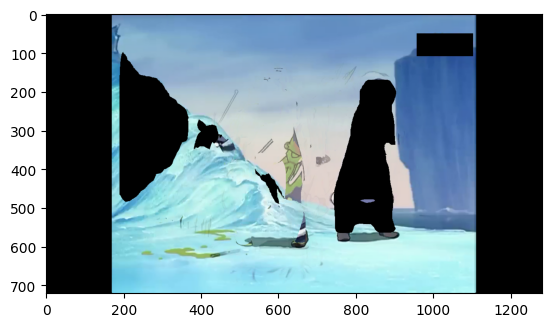

In [29]:
plt.imshow(total_bg)

In [74]:
Ms[0].dtype

dtype('float64')

In [21]:
padding = get_new_window_padding(test_frame1.shape)
total_bg,total_mask = prepare_total_resample(total_bg,total_mask,padding)

In [87]:
new_frame,total_bg2 = resample_frame(test_frame1,bg_mask1, Ms[0], total_bg, total_mask, pipe)

(721, 1282, 3) (721, 1282)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

(720, 940, 3)
float64


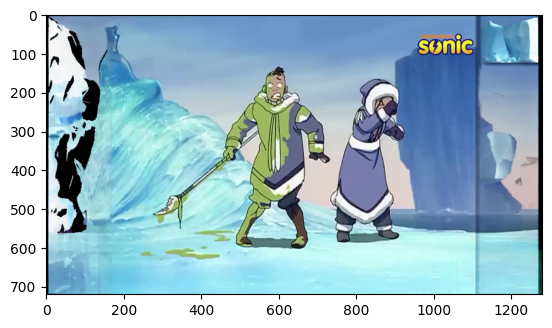

In [88]:
plt.imshow(new_frame,'gray')

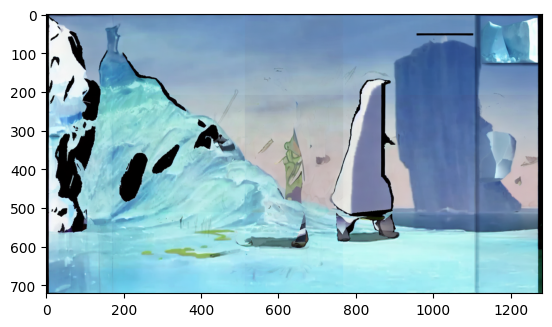

In [89]:
plt.imshow(total_bg2,'gray')